In [2299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import necessary modules from scikit-learn for pipline
from sklearn import set_config
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



In [2300]:
trainset = pd.read_csv('./Dataset/LoanPrediction_TrainSet.csv')
testset = pd.read_csv('./DataSet/LoanPrediction_TestSet.csv')



# Data Exploration:

In [2301]:
trainset.head(10)

,Unnamed: 0,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [2302]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         614 non-null    int64  
 1   LoanID             614 non-null    object 
 2   Gender             601 non-null    object 
 3   Married            611 non-null    object 
 4   Dependents         599 non-null    object 
 5   Education          614 non-null    object 
 6   SelfEmployed       582 non-null    object 
 7   ApplicantIncome    614 non-null    int64  
 8   CoapplicantIncome  614 non-null    float64
 9   LoanAmount         592 non-null    float64
 10  LoanAmountTerm     600 non-null    float64
 11  CreditHistory      564 non-null    float64
 12  PropertyArea       614 non-null    object 
 13  LoanStatus         614 non-null    object 
dtypes: float64(4), int64(2), object(8)
memory usage: 67.3+ KB


### Analytics Base Table ABT

In [2303]:

ABT_train = trainset.describe(include="all").T

ABT_train = ABT_train.reset_index().rename(columns={'index': 'Feature'})
ABT_train['Missing'] = trainset.isnull().sum().values
ABT_train['dtype'] = trainset.dtypes.values
ABT_train.to_excel('ABT_train.xlsx', index=False)
ABT_train


# Wrong data types for some features like 'Dependents' and 'Credit_History' and missing values in some features
# There is some unbalance in the target variable 'Loan_Status' 
# Dependents looks like it have some not allowed additions sign as well for 3+ as a category which i will fix
# Bias in features for example Gender more male and females
# Looks like there is Outliers in the features ApplicantIncome, CoapplicantIncome and LoanAmount


,Feature,count,unique,top,freq,mean,std,min,25%,50%,75%,max,Missing,dtype
0,Unnamed: 0,614.0,NaN,NaN,NaN,306.5,177.390811,0.0,153.25,306.5,459.75,613.0,0,int64
1,LoanID,614,614,LP001002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
2,Gender,601,2,Male,489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,object
3,Married,611,2,Yes,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,object
4,Dependents,599,4,0,345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,object
5,Education,614,2,Graduate,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
6,SelfEmployed,582,2,No,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,object
7,ApplicantIncome,614.0,NaN,NaN,NaN,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.0,81000.0,0,int64
8,CoapplicantIncome,614.0,NaN,NaN,NaN,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0,0,float64
9,LoanAmount,592.0,NaN,NaN,NaN,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0,22,float64


# Take a closer look at features that looks like they have outliers

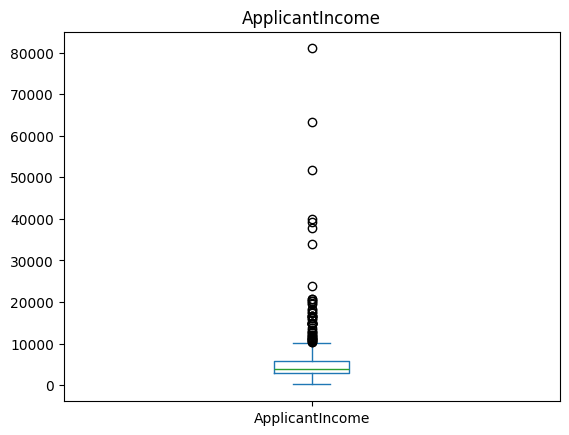

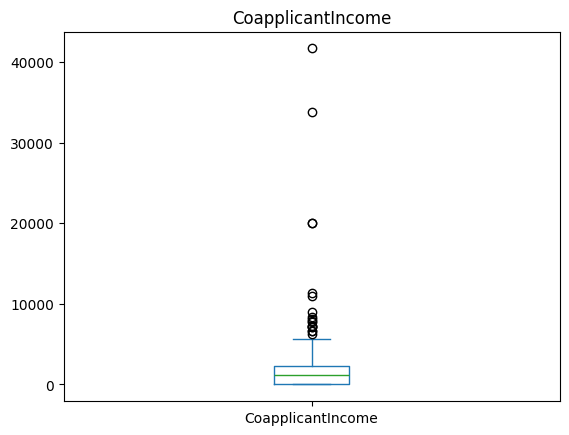

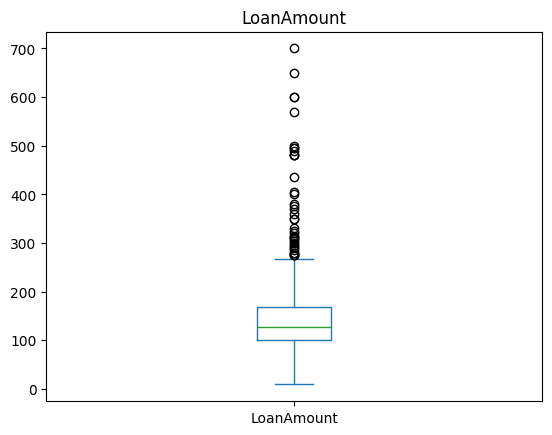

In [2304]:

for col in ["ApplicantIncome","CoapplicantIncome","LoanAmount"]:
    trainset[col].plot(kind="box")
    plt.title(col)
    plt.show()


# Top 5  highly correlated variables with the target variable ‘LoanStatus’

In [2305]:
# drop LoanID and Unnamed as it is not useful for prediction and not affect correlation
trainset = trainset.drop(columns=['LoanID',"Unnamed: 0"])
testset = testset.drop(columns=['LoanID',"Unnamed: 0"])

X_num = trainset.select_dtypes(include="number")
X_cat = pd.get_dummies(trainset.select_dtypes(exclude="number"), drop_first=True)
y = trainset['LoanStatus'].map({'Y':1, 'N':0})

X_eda = pd.concat([X_num, X_cat], axis=1)
corr = X_eda.corrwith(y)

corrtop = corr.sort_values(ascending=False).head(15)
corrtop.to_excel('Top5_correlated_features.xlsx', index=True)

corrtop

LoanStatus_Y              1.000000
CreditHistory             0.561678
PropertyArea_Semiurban    0.136540
Married_Yes               0.084281
Dependents_2              0.062384
Gender_Male               0.025407
SelfEmployed_Yes         -0.003700
ApplicantIncome          -0.004710
LoanAmountTerm           -0.021268
Dependents_3+            -0.026123
LoanAmount               -0.037318
Dependents_1             -0.038740
PropertyArea_Urban       -0.043621
CoapplicantIncome        -0.059187
Education_Not Graduate   -0.085884
dtype: float64

In [2306]:
X_eda

,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,SelfEmployed_Yes,PropertyArea_Semiurban,PropertyArea_Urban,LoanStatus_Y
0,5849,0.0,NaN,360.0,1.0,True,False,False,False,False,False,False,False,True,True
1,4583,1508.0,128.0,360.0,1.0,True,True,True,False,False,False,False,False,False,False
2,3000,0.0,66.0,360.0,1.0,True,True,False,False,False,False,True,False,True,True
3,2583,2358.0,120.0,360.0,1.0,True,True,False,False,False,True,False,False,True,True
4,6000,0.0,141.0,360.0,1.0,True,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.0,360.0,1.0,False,False,False,False,False,False,False,False,False,True
610,4106,0.0,40.0,180.0,1.0,True,True,False,False,True,False,False,False,False,True
611,8072,240.0,253.0,360.0,1.0,True,True,True,False,False,False,False,False,True,True
612,7583,0.0,187.0,360.0,1.0,True,True,False,True,False,False,False,False,True,True


### Group the instances of the train dataset into four bins considering ‘Dependents’ (0, 1, 2 and 3+) and plot a bar chart illustrating the binning.

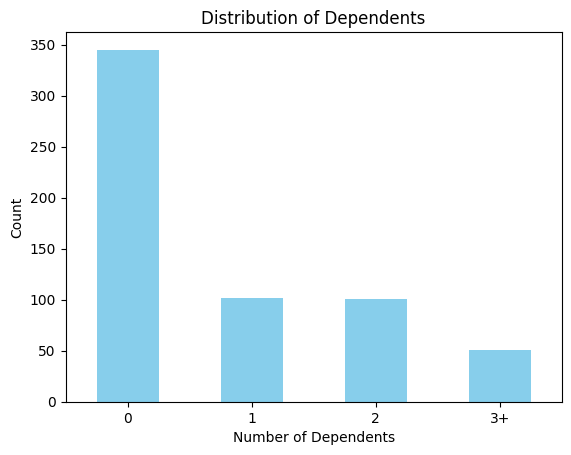

In [2307]:
# Group the instances of the train dataset into four bins considering ‘Dependents’ (0, 1, 2 and 3+) and plot a bar chart illustrating the binning.

dependents_count = trainset['Dependents'].value_counts()
dependents_count.plot(kind='bar', color='skyblue')
plt.xlabel('Number of Dependents')
plt.ylabel('Count')
plt.title('Distribution of Dependents')
plt.xticks(rotation=0)
plt.show()

# Data Pre-processing:

In [2308]:
# got some extreme outluers in the features so i will log transform them
skewed_features = ["ApplicantIncome","CoapplicantIncome","LoanAmount"]

def logtransformer(dataset, features):
    dataset = dataset.copy()
    dataset[features] = np.log1p(dataset[features])
    return dataset


In [2309]:
# fix dependents
trainset['Dependents'] = trainset['Dependents'].replace('3+', 3).astype(float)
testset['Dependents'] = testset['Dependents'].replace('3+', 3).astype(float)

X_train = trainset.drop(columns=['LoanStatus'])
y_train = trainset['LoanStatus'].map({'N':0, 'Y':1})

X_test = testset.drop(columns=['LoanStatus'])
y_test = testset['LoanStatus'].map({'N':0, 'Y':1})


# Feature Engineering:

In [2310]:

def feature_engineering(df):
    df = df.copy()
    """ Feature engineering to create new features that might be useful for prediction.
    Fixing LoanAmount scale by multiplying by 1000 to get correct monthly payments per month
    """
    df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['InstalmentAmount'] = (df['LoanAmount']*1000) / df['LoanAmountTerm']
    df['BalancedIncome'] = df['TotalIncome'] - df['InstalmentAmount']
    return df

# Development of Predictive Models pipline:

In [2311]:

set_config(transform_output="pandas")

num_select = make_column_selector(dtype_include=np.number)
cat_select = make_column_selector(dtype_include=object)

impute = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), num_select),
    ('cat', SimpleImputer(strategy='most_frequent'), cat_select),
], verbose_feature_names_out=False)

feature_engineered = FunctionTransformer(feature_engineering)

num_pipeline = Pipeline(steps=[
    ('logtransformer', FunctionTransformer(logtransformer, kw_args={'features': skewed_features}, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
    
])
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocess = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_select),
    ('cat', cat_pipeline, cat_select)
],   verbose_feature_names_out=False)  


num_cols = num_select(X_train)
cat_cols = cat_select(X_train)

print("Numerical:", num_cols)
print("Categorical:", cat_cols)



Numerical: ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'LoanAmountTerm', 'CreditHistory']
Categorical: ['Gender', 'Married', 'Education', 'SelfEmployed', 'PropertyArea']


# Its a classification problem sow will use LogisticRegression as base model 
### And use SMOTE for uppsampling the dataset becuase of unbalanced classes 

In [2312]:
logistic_model= Pipeline(steps =[
    ('impute',impute),
    ('feature_engineering',feature_engineered),
    ('preprocess',preprocess),
    ('uppsamp', SMOTE()),
     ('model',LogisticRegression(max_iter=300))
] )
logistic_model                          

,steps,"[('impute', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [2313]:
decisiontree_model= Pipeline(steps =[
    ('impute',impute),
    ('feature_engineering',feature_engineered),
    ('preprocess',preprocess),
    ('uppsamp', SMOTE(k_neighbors=5)),
     ('model',DecisionTreeClassifier(max_depth=3, min_samples_leaf=2))
] )
                            
decisiontree_model

,steps,"[('impute', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


## Take a look at the preprocessed data before training the models

In [2314]:
X_imp = logistic_model.named_steps['impute'].fit_transform(X_train, y_train)
X_feat = logistic_model.named_steps['feature_engineering'].fit_transform(X_imp)
X_prep = logistic_model.named_steps['preprocess'].fit_transform(X_feat)

feature_names = logistic_model.named_steps['preprocess'].get_feature_names_out()

sm = logistic_model.named_steps['uppsamp']

X_res, y_res = sm.fit_resample(X_prep, y_train)
print(f"Before resampling: {np.bincount(y_train)}")
print(f"After resampling: {np.bincount(y_res)}")

X_train_proccessed = pd.DataFrame(X_res, columns=feature_names)
X_train_proccessed.info()
proccessed_desccribe = X_train_proccessed.describe().T
proccessed_desccribe

Before resampling: [192 422]
After resampling: [422 422]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dependents              844 non-null    float64
 1   ApplicantIncome         844 non-null    float64
 2   CoapplicantIncome       844 non-null    float64
 3   LoanAmount              844 non-null    float64
 4   LoanAmountTerm          844 non-null    float64
 5   CreditHistory           844 non-null    float64
 6   TotalIncome             844 non-null    float64
 7   InstalmentAmount        844 non-null    float64
 8   BalancedIncome          844 non-null    float64
 9   Gender_Female           844 non-null    float64
 10  Gender_Male             844 non-null    float64
 11  Married_No              844 non-null    float64
 12  Married_Yes             844 non-null    float64
 13  Education_Graduate      844 non-null  

,count,mean,std,min,25%,50%,75%,max
Dependents,844.0,-0.023703,0.976971,-0.761490,-7.614903e-01,-0.761490,0.236612,2.232816
ApplicantIncome,844.0,0.008781,0.993175,-5.157770,-5.727312e-01,-0.130928,0.477657,4.593738
CoapplicantIncome,844.0,-0.014682,0.998192,-1.107783,-1.107783e+00,0.707359,0.889504,1.638995
LoanAmount,844.0,0.004201,0.991874,-5.230981,-4.649594e-01,0.008810,0.453950,3.425087
LoanAmountTerm,844.0,0.030404,0.957458,-5.130593,2.798505e-01,0.279851,0.279851,2.145521
CreditHistory,844.0,-0.179143,1.147081,-2.410441,3.177548e-16,0.451640,0.451640,0.451640
TotalIncome,844.0,-0.002016,0.992487,-0.865079,-4.429764e-01,-0.246621,0.049117,11.462992
InstalmentAmount,844.0,-0.016951,0.898563,-0.883589,-3.630396e-01,-0.203493,0.053583,17.185199
BalancedIncome,844.0,-0.000693,0.993722,-1.323189,-4.360519e-01,-0.245721,0.047359,11.686291
Gender_Female,844.0,0.180239,0.375548,0.000000,0.000000e+00,0.000000,0.000000,1.000000


In [2315]:
X_train_proccessed.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,TotalIncome,InstalmentAmount,BalancedIncome,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,SelfEmployed_No,SelfEmployed_Yes,PropertyArea_Rural,PropertyArea_Semiurban,PropertyArea_Urban
0,-0.761490,0.516186,-1.107783,0.249219,0.279851,0.45164,-0.182184,-0.135961,-0.176013,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.236612,0.137806,0.782158,-0.022525,0.279851,0.45164,-0.144684,-0.236137,-0.129373,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.761490,-0.519479,-1.107783,-1.356846,0.279851,0.45164,-0.623656,-0.573465,-0.593758,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.761490,-0.751605,0.897526,-0.152922,0.279851,0.45164,-0.322885,-0.279664,-0.308805,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,-0.761490,0.555727,-1.107783,0.173033,0.279851,0.45164,-0.158785,-0.165407,-0.149597,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


# Train Model Logistic

In [2316]:
logistic_model.fit(X_train, y_train)


,steps,"[('impute', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


# Train Model Decision tree

In [2317]:
decisiontree_model.fit(X_train, y_train)

,steps,"[('impute', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


# Evaluation and Discussion:

If dataset is keept unbalanced regarding classes logistic model score 98,36% 
and decision tree 77.65%



logistic_model.score(X_test, y_test)

In [2319]:
decisiontree_model.score(X_test, y_test)

0.989100817438692

In [2323]:
X_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,356,2,Male,286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,367,2,Yes,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,357.0,NaN,NaN,NaN,0.829132,1.071302,0.0,0.0,0.0,2.0,3.0
Education,367,2,Graduate,283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SelfEmployed,344,2,No,307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ApplicantIncome,367.0,NaN,NaN,NaN,4805.599455,4910.685399,0.0,2864.0,3786.0,5060.0,72529.0
CoapplicantIncome,367.0,NaN,NaN,NaN,1569.577657,2334.232099,0.0,0.0,1025.0,2430.5,24000.0
LoanAmount,362.0,NaN,NaN,NaN,136.132597,61.366652,28.0,100.25,125.0,158.0,550.0
LoanAmountTerm,361.0,NaN,NaN,NaN,342.537396,65.156643,6.0,360.0,360.0,360.0,480.0
CreditHistory,338.0,NaN,NaN,NaN,0.825444,0.38015,0.0,1.0,1.0,1.0,1.0


In [2320]:
# precision recall f1-score
from sklearn.metrics import classification_report
y_pred_logistic = logistic_model.predict(X_test)
y_pred_decisiontree = decisiontree_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logistic))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_decisiontree))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.95      0.70        63
           1       0.99      0.84      0.91       304

    accuracy                           0.86       367
   macro avg       0.77      0.90      0.81       367
weighted avg       0.91      0.86      0.87       367

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        63
           1       0.99      1.00      0.99       304

    accuracy                           0.99       367
   macro avg       0.99      0.97      0.98       367
weighted avg       0.99      0.99      0.99       367



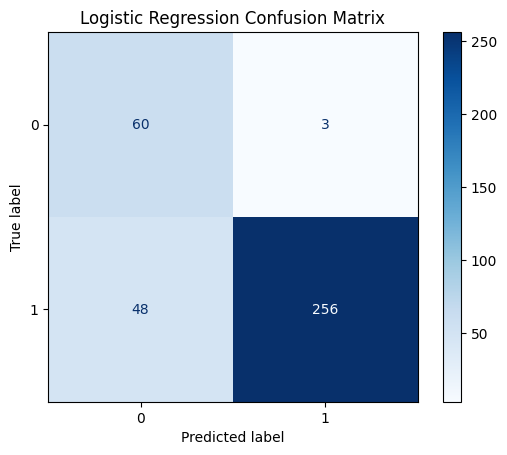

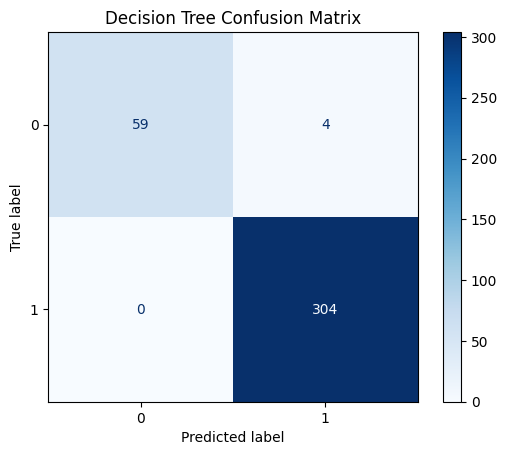

In [2321]:
# Logistic Regression confusion matrix
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic)
disp_logistic.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Decision Tree confusion matrix
cm_tree = confusion_matrix(y_test, y_pred_decisiontree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree)
disp_tree.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()


In [2325]:
print("LoanStatus in X_train?", "LoanStatus" in X_train.columns)
feat_names = decisiontree_model.named_steps['preprocess'].get_feature_names_out()
[f for f in feat_names if "LoanStatus" in f]  # ska vara tomt

import numpy as np
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report

print("y_test dist:", np.bincount(y_test))  # ska vara [63, 304] ungefär

yhat_tree = decisiontree_model.predict(X_test)
print("Balanced acc (tree):", balanced_accuracy_score(y_test, yhat_tree))
print("CM (tree):\n", confusion_matrix(y_test, yhat_tree))
print(classification_report(y_test, yhat_tree, digits=3))


LoanStatus in X_train? False
y_test dist: [ 63 304]
Balanced acc (tree): 0.9682539682539683
CM (tree):
 [[ 59   4]
 [  0 304]]
              precision    recall  f1-score   support

           0      1.000     0.937     0.967        63
           1      0.987     1.000     0.993       304

    accuracy                          0.989       367
   macro avg      0.994     0.968     0.980       367
weighted avg      0.989     0.989     0.989       367



In [2326]:
import pandas as pd
pd.crosstab(y_test, X_test["CreditHistory"], rownames=["LoanStatus"], colnames=["CreditHistory"])


CreditHistory,0.0,1.0
LoanStatus,,
0,59,4
1,0,275


In [2327]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(decisiontree_model, X_train, y_train, cv=cv, scoring="balanced_accuracy")
scores.mean(), scores.std()


(0.703276063461822, 0.0234154030163529)

In [2328]:
from sklearn.tree import export_text
tree = decisiontree_model.named_steps["model"]
fn = decisiontree_model.named_steps["preprocess"].get_feature_names_out().tolist()
print(export_text(tree, feature_names=fn, max_depth=3))


|--- CreditHistory <= -0.01
|   |--- ApplicantIncome <= 3.33
|   |   |--- CoapplicantIncome <= 1.23
|   |   |   |--- class: 0
|   |   |--- CoapplicantIncome >  1.23
|   |   |   |--- class: 0
|   |--- ApplicantIncome >  3.33
|   |   |--- class: 0
|--- CreditHistory >  -0.01
|   |--- PropertyArea_Semiurban <= 1.00
|   |   |--- PropertyArea_Semiurban <= 0.01
|   |   |   |--- class: 1
|   |   |--- PropertyArea_Semiurban >  0.01
|   |   |   |--- class: 0
|   |--- PropertyArea_Semiurban >  1.00
|   |   |--- LoanAmount <= 0.28
|   |   |   |--- class: 1
|   |   |--- LoanAmount >  0.28
|   |   |   |--- class: 1

